**Forecasting time series for Sunspot using cnn and lstm**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

helper function to show result

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
      for y_curr in y:
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
      plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

download sunspots datasets

In [3]:
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-01-10 18:17:23--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0b::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.002s  

2024-01-10 18:17:23 (33.4 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



plot by mounth

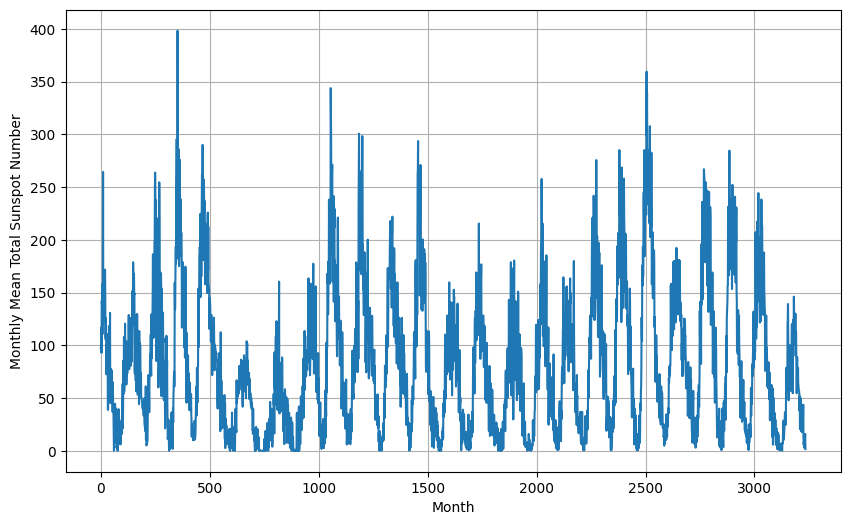

In [4]:
time_step = []
sunspots = []
with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))
time = np.array(time_step)
series = np.array(sunspots)
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

split to train and test

In [5]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

prepare our data

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

make our model and found optimize learning rate

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 68575 (267.87 KB)
Trainable params: 68575 

In [9]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 15s 10ms/step - loss: 82.2164 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 1s 12ms/step - loss: 82.2162 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 1s 9ms/step - loss: 82.2160 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 1s 9ms/step - loss: 82.2157 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 1s 9ms/step - loss: 82.2154 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 1s 9ms/step - loss: 82.2151 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 1s 9ms/step - loss: 82.2148 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 1s 9ms/step - loss: 82.2144 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 1s 9ms/step - loss: 82.2139 - lr: 2.5119e-08
Epoch 10/100
94/94 [==============================] - 1s 8ms/step - loss: 82.2134 - lr: 2.8184e-08
Epoch 11/100
94/

(1e-08, 0.001, 0.0, 100.0)

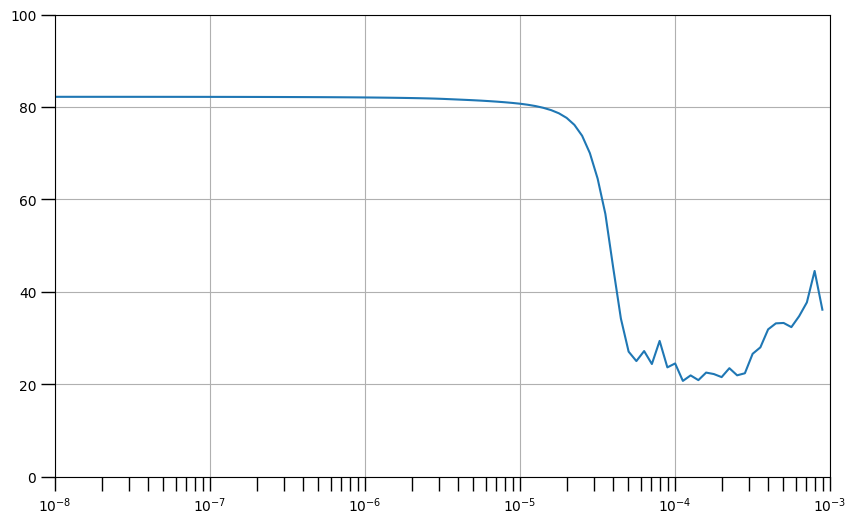

In [10]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 100])

Our optimize learning rate is 2e-5

In [11]:
learning_rate = 2e-5
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["MAPE"])

In [12]:
history = model.fit(train_set,epochs=100,)


Epoch 1/100
94/94 [==============================] - 4s 8ms/step - loss: 31.2488 - MAPE: 214481280.0000
Epoch 2/100
94/94 [==============================] - 1s 9ms/step - loss: 30.4509 - MAPE: 182643696.0000
Epoch 3/100
94/94 [==============================] - 1s 9ms/step - loss: 30.4993 - MAPE: 153500256.0000
Epoch 4/100
94/94 [==============================] - 1s 10ms/step - loss: 28.0006 - MAPE: 130245088.0000
Epoch 5/100
94/94 [==============================] - 1s 13ms/step - loss: 25.5287 - MAPE: 105294264.0000
Epoch 6/100
94/94 [==============================] - 1s 8ms/step - loss: 23.3077 - MAPE: 106293880.0000
Epoch 7/100
94/94 [==============================] - 1s 9ms/step - loss: 21.9124 - MAPE: 126378280.0000
Epoch 8/100
94/94 [==============================] - 1s 9ms/step - loss: 21.9030 - MAPE: 135612432.0000
Epoch 9/100
94/94 [==============================] - 1s 9ms/step - loss: 20.9496 - MAPE: 138778064.0000
Epoch 10/100
94/94 [==============================] - 1s 9ms/s

try to make it better

In [28]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=8,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(100, return_sequences=True),
  tf.keras.layers.LSTM(120, return_sequences=True),
  tf.keras.layers.LSTM(100),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 20, 64)            576       
                                                                 
 lstm_10 (LSTM)              (None, 20, 100)           66000     
                                                                 
 lstm_11 (LSTM)              (None, 20, 120)           106080    
                                                                 
 lstm_12 (LSTM)              (None, 100)               88400     
                                                                 
 dense_15 (Dense)            (None, 20)                2020      
                                                                 
 dense_16 (Dense)            (None, 10)                210       
                                                                 
 dense_17 (Dense)            (None, 1)                

In [29]:
learning_rate = 2e-5
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["MAPE"])

In [30]:
history = model.fit(train_set,epochs=300)

Epoch 1/300
94/94 [==============================] - 20s 11ms/step - loss: 82.3616 - MAPE: 1525947.2500
Epoch 2/300
94/94 [==============================] - 1s 13ms/step - loss: 82.2796 - MAPE: 577802.2500
Epoch 3/300
94/94 [==============================] - 1s 13ms/step - loss: 82.2309 - MAPE: 971608.6250
Epoch 4/300
94/94 [==============================] - 2s 17ms/step - loss: 82.1839 - MAPE: 1834734.5000
Epoch 5/300
94/94 [==============================] - 1s 11ms/step - loss: 82.1365 - MAPE: 2648283.0000
Epoch 6/300
94/94 [==============================] - 1s 11ms/step - loss: 82.0873 - MAPE: 3433471.0000
Epoch 7/300
94/94 [==============================] - 1s 11ms/step - loss: 82.0346 - MAPE: 4288616.0000
Epoch 8/300
94/94 [==============================] - 1s 10ms/step - loss: 81.9774 - MAPE: 5223672.5000
Epoch 9/300
94/94 [==============================] - 1s 11ms/step - loss: 81.9153 - MAPE: 6300921.0000
Epoch 10/300
94/94 [==============================] - 1s 11ms/step - loss:

with larger kernel size i get better result

In [31]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)

    return forecast

8/8 [==============================] - 1s 13ms/step


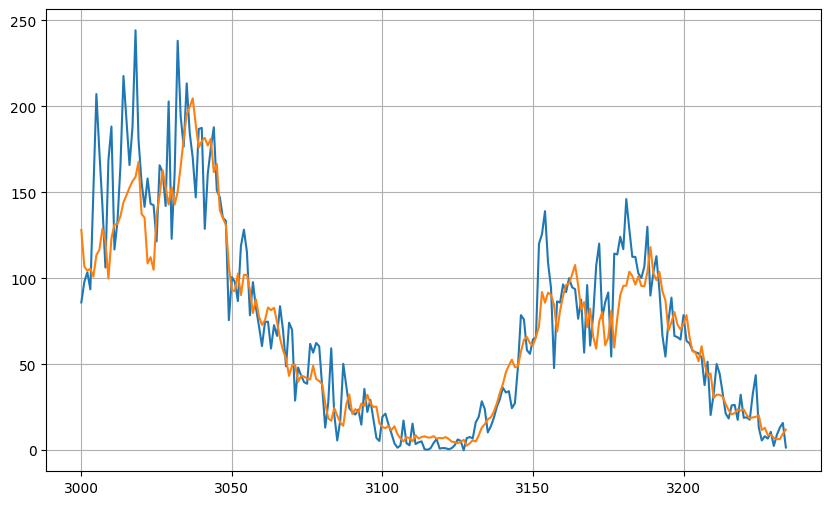

In [32]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [33]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

15.462344


Thanks for your attention